In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
img_dir = "/content/drive/MyDrive/FingerHeart/data"
img_size = (160, 160)

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    subset = "training",
    seed = 123,
    validation_split = 0.2,
    image_size = img_size,
    batch_size = 16
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    subset = "validation",
    seed = 123,
    validation_split = 0.2,
    image_size = img_size,
    batch_size = 16
)


Found 60 files belonging to 2 classes.
Using 48 files for training.
Found 60 files belonging to 2 classes.
Using 12 files for validation.


In [5]:
class_names = train_dataset.class_names
class_names

['FingerHeart', 'Peace']

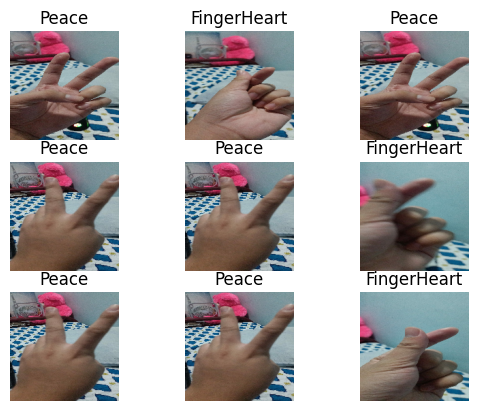

In [6]:
for image, label in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
val_dataset =val_dataset.prefetch(buffer_size = AUTOTUNE)

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

In [11]:
rescale = tf.keras.layers.Rescaling(1/ 127.5, offset = -1)
img_size = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = img_size, include_top = False, weights = "imagenet")

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

global_average = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average(feature_batch)

prediction_layer = tf.keras.layers.Dense(1, activation = "sigmoid")
prediction_batch = prediction_layer(feature_batch_average)

In [12]:
base_model.trainable = False

In [13]:
i = tf.keras.layers.Input(shape = (160, 160, 3))
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer(x)

model = tf.keras.models.Model(i, x)


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [15]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ["accuracy"])

In [16]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    verbose = 1,
    restore_best_weights = "True",
    min_delta = 0.1
)
logs = "/content/drive/MyDrive/FingerHeart/logs"
TensorBoard = tf.keras.callbacks.TensorBoard(log_dir = logs)

In [17]:
r = model.fit(train_dataset, epochs = 10, validation_data = val_dataset, callbacks = [Early_Stopping, TensorBoard])

Epoch 1/10
3/3 [==============================] - 17s 2s/step - loss: 0.6084 - accuracy: 0.6667 - val_loss: 0.5561 - val_accuracy: 0.7500
Epoch 2/10
3/3 [==============================] - 3s 351ms/step - loss: 0.7318 - accuracy: 0.6667 - val_loss: 0.5463 - val_accuracy: 0.7500
Epoch 3/10
3/3 [==============================] - 2s 204ms/step - loss: 0.7088 - accuracy: 0.5208 - val_loss: 0.5383 - val_accuracy: 0.7500
Epoch 4/10
3/3 [==============================] - 1s 193ms/step - loss: 0.5580 - accuracy: 0.7292 - val_loss: 0.5314 - val_accuracy: 0.8333
Epoch 5/10
3/3 [==============================] - 2s 204ms/step - loss: 0.6754 - accuracy: 0.6667 - val_loss: 0.5258 - val_accuracy: 0.8333
Epoch 6/10
3/3 [==============================] - 2s 257ms/step - loss: 0.6994 - accuracy: 0.5417 - val_loss: 0.5206 - val_accuracy: 0.9167
Epoch 6: early stopping


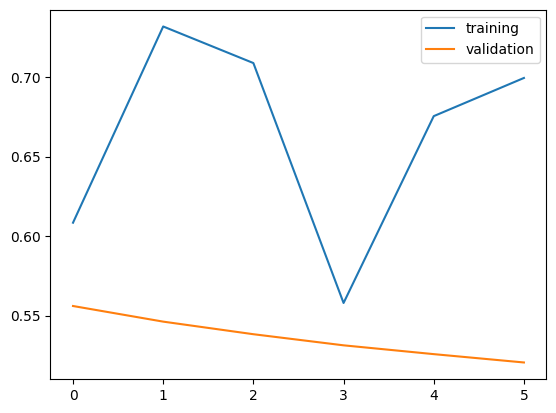

In [18]:
plt.plot(r.history['loss'], label = "training")
plt.plot(r.history["val_loss"], label = "validation")
plt.legend()

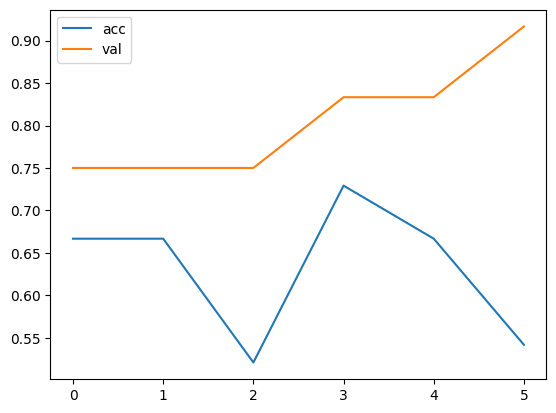

In [19]:
plt.plot(r.history["accuracy"], label = "acc")
plt.plot(r.history["val_accuracy"], label = "val")
plt.legend()

In [20]:
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [21]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001/10), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ["accuracy"])

In [38]:
r = model.fit(train_dataset, epochs = 20, initial_epoch = r.epoch[-1], validation_data=val_dataset, callbacks = [Early_Stopping, TensorBoard])

Epoch 12/20
3/3 [==============================] - 2s 295ms/step - loss: 0.1877 - accuracy: 0.9583 - val_loss: 0.2612 - val_accuracy: 1.0000
Epoch 13/20
3/3 [==============================] - 2s 219ms/step - loss: 0.1786 - accuracy: 0.9583 - val_loss: 0.1910 - val_accuracy: 0.9167
Epoch 14/20
3/3 [==============================] - 1s 211ms/step - loss: 0.1237 - accuracy: 0.9792 - val_loss: 0.1627 - val_accuracy: 1.0000
Epoch 15/20
3/3 [==============================] - 2s 393ms/step - loss: 0.0991 - accuracy: 0.9792 - val_loss: 0.1499 - val_accuracy: 1.0000
Epoch 16/20
3/3 [==============================] - 2s 207ms/step - loss: 0.1171 - accuracy: 0.9583 - val_loss: 0.1528 - val_accuracy: 0.9167
Epoch 17/20
3/3 [==============================] - 2s 226ms/step - loss: 0.0593 - accuracy: 1.0000 - val_loss: 0.1193 - val_accuracy: 1.0000
Epoch 18/20
3/3 [==============================] - 2s 309ms/step - loss: 0.0609 - accuracy: 0.9792 - val_loss: 0.0981 - val_accuracy: 1.0000
Epoch 19/20
3

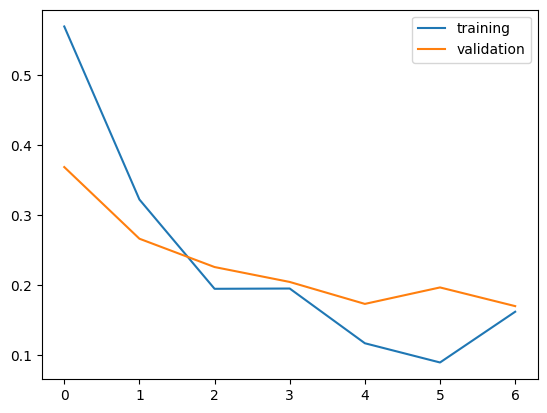

In [23]:
plt.plot(r.history['loss'], label = "training")
plt.plot(r.history["val_loss"], label = "validation")
plt.legend()

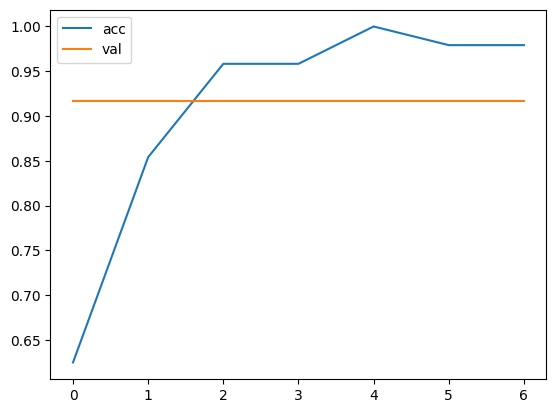

In [24]:
plt.plot(r.history["accuracy"], label = "acc")
plt.plot(r.history["val_accuracy"], label = "val")
plt.legend()

In [25]:
import cv2

In [44]:
img = cv2.imread("/content/drive/MyDrive/FingerHeart/testing/IMG20231220004122.jpg")
img = tf.image.resize(img, size = (160, 160))
img_to_array = tf.keras.utils.img_to_array(img)
img_to_array = tf.expand_dims(img_to_array, 0)
model.predict(img_to_array)

1/1 [==============================] - 0s 35ms/step


array([[0.411759]], dtype=float32)

1/1 [==============================] - 0s 35ms/step


array([[0.72062075]], dtype=float32)

In [45]:
model.save("FingerHeart.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
